# Gradient Boosting Machines

In [1]:
import os
os.chdir("D:/ML_Projects/MercedesBenz-Kaggle/")
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold, learning_curve
import sklearn.metrics as mt
from sklearn import ensemble
np.random.seed(12548)

## Read and preprocess data

In [2]:
def read_data():
    train_data = pd.read_csv("./data/train.csv")
    test_data = pd.read_csv("./data/test.csv")
    return train_data, test_data


def process_data(train_data, test_data):
    binary_cols, all_zero_cols, all_one_cols = [],[],[]
    for col in train_data.iloc[:,10:]:
        unique_vals = train_data[col].unique()
        if np.array_equal(unique_vals, [1,0]) or np.array_equal(unique_vals, [0,1]):
            binary_cols.append(col)
        elif np.array_equal(unique_vals, [0]):
            all_zero_cols.append(col)
        elif np.array_equal(unique_vals, [1]):
            all_one_cols.append(col)
        else:
            print(unique_vals)

    # Drop columns with only zeros
    train_data = train_data.drop(all_zero_cols, axis=1)
    test_data = test_data.drop(all_zero_cols, axis=1)
    
    train_cat_cols = train_data.iloc[:,2:10]
    test_cat_cols = test_data.iloc[:,1:9]
    freq=[]
    col_names = []
    cat_mismatch = []
    
    for train_col, test_col in zip(train_cat_cols, test_cat_cols):
        col_names.append(train_col)
        train_freq = len(train_cat_cols[train_col].unique())
        test_freq = len(test_cat_cols[test_col].unique())
        
        if train_freq!=test_freq:
            cat_mismatch.append(train_col)
            
        freq.append([train_freq, test_freq])
    freq = pd.DataFrame(freq, columns=['Train_Freq', 'Test_Freq'], index=col_names)
    
    train_data = train_data.drop(cat_mismatch, axis=1)
    test_data = test_data.drop(cat_mismatch, axis=1)
    return train_data, test_data


def prepare_data_ml(train_data, test_data):
    X_train = pd.get_dummies(train_data)
    X_train = X_train.drop(['ID','y'], axis=1).values
    y_train = train_data.y.values
    
    X_test = pd.get_dummies(test_data)
    y_test_id = test_data.ID.values
    X_test = X_test.drop(['ID'], axis=1).values
    
    return X_train, y_train, X_test, y_test_id

def make_submission(reg_estimator, X_test, ID, fname='FinalSubmission'):
    y_pred = reg_estimator.predict(X_test)
    final_submission = pd.DataFrame(np.hstack([ID[:,np.newaxis], y_pred[:,np.newaxis]]), columns=['ID','y'])
    final_submission.ID = final_submission.ID.astype(int)
    final_submission.to_csv('./results/'+fname, index=False)
    return final_submission

## Grid Search

In [5]:
def gridSearch_gbm(X_train, y_train, K=5):
    param_grid = param_grid = {'n_estimators': [100,500,1000], 'max_depth': [3,5,10],
                               'min_samples_split': [2],
                               'learning_rate':[10e-3, 10e-2,10e-1] ,
                               'loss': ['ls','huber'],
                               'subsample':[1], 'max_features':['sqrt','log2'],
                               'criterion':['friedman_mse']}

    cv_kfold = KFold(n_splits=K, shuffle=True, random_state=12548)

    gbm_regressor = ensemble.GradientBoostingRegressor(random_state=122)

    gs_gbm = GridSearchCV(estimator=gbm_regressor,
                          param_grid=param_grid,
                          scoring='r2',
                          cv=cv_kfold,
                          n_jobs=-1,
                          verbose=1)
    gs_gbm.fit(X_train, y_train)
    print(gs_gbm.best_score_)
    return gs_gbm.best_estimator_

def run_gridSearch_gbm():
    print("Read and preprocess data")

    train_data, test_data = read_data()
    train_data, test_data = process_data(train_data, test_data)

    X_train, y_train, X_test, y_test_id = prepare_data_ml(train_data, test_data)

    print("Training Samples: ", X_train.shape)
    print("Test Sample: ", X_test.shape)

    print("============ Grid Search GBM ================")

    gbm_best_estimator = gridSearch_gbm(X_train, y_train, K=3)
    print(gbm_best_estimator)
    return gbm_best_estimator

gbm_best_estimator = run_gridSearch_gbm()

Read and preprocess data
Training Samples:  (4209, 431)
Test Sample:  (4209, 431)
============ Grid Search GBM ================
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  8.9min finished


0.55961990589
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=122,
             subsample=1, verbose=0, warm_start=False)


## Evaluate best estimator

In [7]:
train_data, test_data = read_data()
train_data, test_data = process_data(train_data, test_data)

X_train, y_train, X_test, y_test_id = prepare_data_ml(train_data, test_data)

print("Training Samples: ", X_train.shape)
print("Test Sample: ", X_test.shape)

Training Samples:  (4209, 431)
Test Sample:  (4209, 431)


In [8]:
def eval_gbm(gbm_regressor, X_train, y_train, K=5):
    cv_ss = ShuffleSplit(n_splits=K, test_size=0.3, random_state=12548)
    reg_scores = []
    
    for train_idx, val_idx in cv_ss.split(X_train, y_train):
        x_train_cv, y_train_cv = X_train[train_idx], y_train[train_idx]
        x_val_cv, y_val_cv = X_train[val_idx], y_train[val_idx]
        
        reg_model = gbm_regressor
        reg_model.fit(x_train_cv, y_train_cv)
        y_pred_cv = reg_model.predict(x_val_cv)
        
        r_2 = mt.r2_score(y_val_cv, y_pred_cv) # Coefficient of determination
        mse = mt.mean_squared_error(y_val_cv, y_pred_cv) # Mean squared error
        explained_var = mt.explained_variance_score(y_val_cv, y_pred_cv) # Explained variance
        
        reg_scores.append([r_2, mse, explained_var])

    reg_scores = pd.DataFrame(reg_scores, columns=['R^2','MSE','Explained_Variance'])
    return reg_scores

gbm_scores = eval_gbm(gbm_best_estimator, X_train, y_train, K=10)

In [9]:
gbm_scores

,R^2,MSE,Explained_Variance
0,0.584149,64.788217,0.584163
1,0.468166,90.012350,0.468169
2,0.590170,60.494783,0.590836
3,0.600907,59.874545,0.601121
4,0.589492,61.065421,0.589493
5,0.482635,91.963143,0.483866
6,0.565567,67.129619,0.565569
7,0.580793,62.216617,0.581467
8,0.591394,66.480366,0.591455
9,0.503943,85.262269,0.503953


In [19]:
def plot_learning_curve(X,y,reg_estimator, cv_estimator, scorer, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=reg_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=False,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training R2')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation R2')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('R2')
    plt.legend(loc='lower right')
    plt.tight_layout()

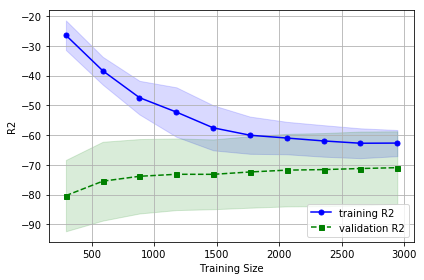

In [20]:
cv_ss = ShuffleSplit(n_splits=10, test_size=0.3, random_state=12548)
plot_learning_curve(X_train, y_train, gbm_best_estimator, cv_ss, scorer='neg_mean_squared_error', xlabel='Training Size')

In [29]:
gbm_regressor_final = gbm_best_estimator
gbm_regressor_final.fit(X_train, y_train)

y_train_pred = gbm_regressor_final.predict(X_train)

r_2 = mt.r2_score(y_train, y_train_pred) # Coefficient of determination
mse = mt.mean_squared_error(y_train, y_train_pred) # Mean squared error
explained_var = mt.explained_variance_score(y_train, y_train_pred) # Explained variance

print("Coefficient of Determination: ", r_2)
print("Mean Square Error: ", mse)
print("Explained Variance: ", explained_var)

Coefficient of Determination:  0.597975444419
Mean Square Error:  64.6168093065
Explained Variance:  0.597975444419


In [31]:
y_test_pred = make_submission(gbm_regressor_final, X_test, y_test_id, fname="GBM_Regression")

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def gridSearch_rf(X_train, y_train, K=5):
    param_grid = param_grid = {'n_estimators': [100,500,1000], 
                               'criterion':['mse','mae'],
                               'max_depth': [3,5,10],
                               'max_features':['sqrt','log2']}

    cv_kfold = KFold(n_splits=K, shuffle=True, random_state=12548)

    rf_regressor = ensemble.RandomForestRegressor(random_state=122)

    gs_rf = GridSearchCV(estimator=rf_regressor,
                          param_grid=param_grid,
                          scoring='r2',
                          cv=cv_kfold,
                          n_jobs=4,
                          verbose=1)
    gs_rf.fit(X_train, y_train)
    print(gs_rf.best_score_)
    return gs_rf.best_estimator_

def run_gridSearch_rf():
    print("Read and preprocess data")

    train_data, test_data = read_data()
    train_data, test_data = process_data(train_data, test_data)

    X_train, y_train, X_test, y_test_id = prepare_data_ml(train_data, test_data)

    print("Training Samples: ", X_train.shape)
    print("Test Sample: ", X_test.shape)

    print("============ Grid Search Random Forest ================")

    rf_best_estimator = gridSearch_rf(X_train, y_train, K=3)
    print(rf_best_estimator)
    return rf_best_estimator

gbm_best_estimator = run_gridSearch_rf()

Read and preprocess data
Training Samples:  (4209, 431)
Test Sample:  (4209, 431)
============ Grid Search Random Forest ================
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.0s
